# Import packages
Note: This notebook can take a while (~5 min) for the first time due to compilation

In [1]:
from pyrms import rms
from diffeqpy import de
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

If you haven't generate the superminimal RMG mechanism yet, remove the `#` in the following cell and run it. This is an example for docker users.

In [3]:
# ! python /rmg/RMG-Py/rmg.py /rmg/RMG-Py/examples/rmg/superminimal/input.py

## Load the mechanism 
<p style="color: red;"> [User input required] </p>

Load the mechanism file from a `.rms` file
```
phase_dict = rms.readinput("/rmg/RMG-Py/examples/rmg/superminimal/rms/chem13.rms")
```
where `mechanism_path` is the path to the generated rms input file

P.S. The same function also works for chemkin files (with thermochemistry and kinetics in the same file):

```
phase_dict = rms.readinput("/rmg/RMG-Py/examples/rmg/superminimal/chemkin/chem_annotated.inp"; 
                           spcdict="chemkin/species_dictionary.txt")
```

In [2]:
mechanism_path = "/rmg/RMG-Py/examples/rmg/superminimal/rms/chem13.rms"  # You may change the path to actual mechanism file path

phase_dict = rms.readinput(mechanism_path)
spcs = phase_dict["phase"]["Species"]
rxns = phase_dict["phase"]["Reactions"]

RDKit WARNING: [16:23:31] WARNING: not removing hydrogen atom without neighbors
[16:23:31] WARNING: not removing hydrogen atom without neighbors


## Change simulation inputs here
<p style="color: red;"> [User input required] </p>

`initial_conds`: a dictionary containing the initial conditions, where
- `T`: temperature (K)
- `P`: pressure (Pa)
- `H2`: number of moles of H2 
- `O2`: number of moles of O2

`tspan`: the simulation time span ($t_0$, $t_f$) in second. E.g., `(0.0, 1.0)` in this example stands for simulating from 0 to 1.0 second

In [4]:
initial_conds = {"T": 1000.0, "P": 1.0e5, "H2": 0.67, "O2": 0.33}
tspan = (0.0, 1.0)

## Set up and Run the simulation
### Make the ideal gas phase
[No User input required]

`Phase` controls how the thermochemical and kinetic properties are calculated. 

In this example, we are using `IdealGas` and assume treating the system as ideal gases. Other `Phase` will be introduced in the `Sensitivity and Simulation using RMS` lecture

In [5]:
ig = rms.IdealGas(spcs, rxns, name="gas")

### Set up the domain
[No User input required]

Domain controls the assumptions made in the simulation (e.g., isothermal, isobaric, adiabatic, etc.)

`ConstantVDomain`: assuming homogeneous constant volume, adiabatic system. The input is the `Phase` and initial conditions. The output is the domain (used to create reactor), y0 the array of initial mole, p the (thermo/kinetic) parameters used of the system

In [6]:
domain, y0, p = rms.ConstantVDomain(phase=ig, initialconds=initial_conds)

### Set up the reactor
[No User input required]

In this step, the ordinary differential equations (ODEs) of the system will be constructed based on the defined domain, initial conditions, and parameters.

In [7]:
react = rms.Reactor(domain, y0, tspan, p=p)

### Solve the ODEs
<p style="color: red;"> [User input optional] </p>

The constructed ODEs will be solved. 

In [8]:
sol = de.solve(react.ode,
               de.CVODE_BDF(),  # You may use a different ODE solver. This is the one also used in Cantera
               abstol=1e-16,  # You may tighter the tolerance with a cost of more computational time
               reltol=1e-8,  # You may tighter the tolerance with a cost of more computational time
               )

### Set up simulation object
[No User input required]

Gathering the simulation results and make it ready to be read, output, and visualized

In [9]:
sim = rms.Simulation(sol, domain)

# Analyze simulation results here

## Plot mole fractions as a function of time
<p style="color: red;"> [User input optional] </p>

Plot mole fractions as a function of time between specified time. You may change the following parameters
- `tf`: final time point to plot (in second)
- `tol`: include the species if its mole fraction is above the tolerance any point in time

Text(0, 0.5, 'Mole Fraction')

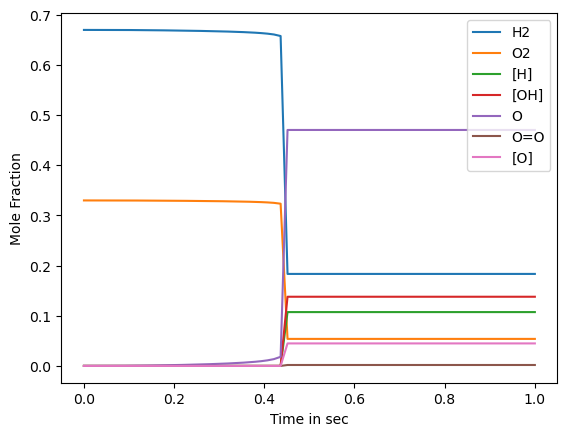

In [10]:
tf = 1.0
tol = 1e-3
rms.plotmolefractions(sim, tf, tol=tol)

## Plot flux diagram
<p style="color: red;"> [User input optional] </p>

Plot flux diagram at time `t` in seconds. You can try different values of `t` between `tspan` you defined 

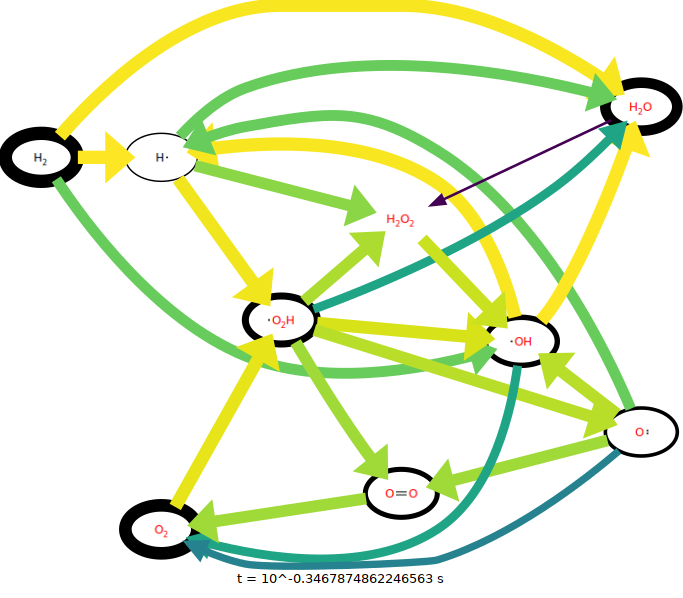

In [11]:
t = 0.45
rms.getfluxdiagram(sim, t)

## Plot ROPs
<p style="color: red;"> [User input optional] </p>

Plot ROPs for specified species at specified time. You can 
- `t`: Plot ROPs at time t (in second). Should be between `tspan`.
- `spc`: The label of the species you want to plot ROP for. (e.g., `O` or `[H]` in this example)

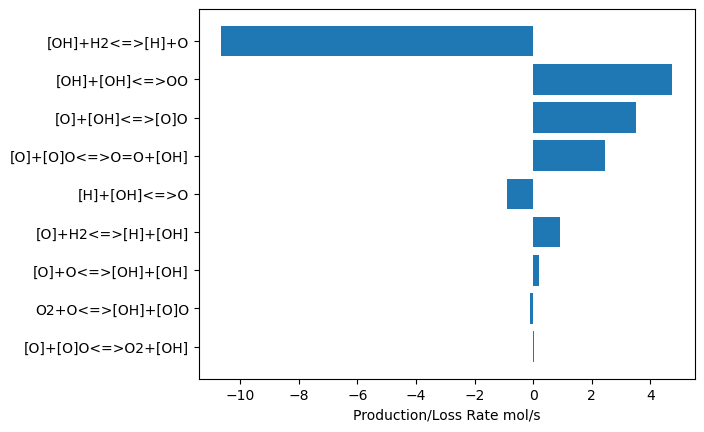

In [12]:
t = 0.45
spc = "[OH]"
rms.plotrops(sim, spc, t)

## Plot radical ROPs

<p style="color: red;"> [User input optional] </p>

Since molecule structure is stored in the RMS mechanism, it can tell which ones are radicals. You are able to plot ROPs regarding the concentration of radicals at specified time point `t` (in second). This is helpful in analyzing the system (e.g., chain-branching reactions), and not available in Chemkin/Cantera. 

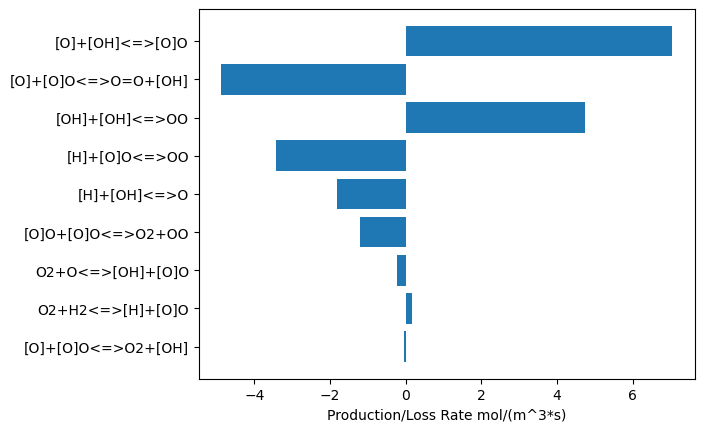

In [13]:
t = 0.45
rms.plotradicalrops(sim, t)

## Next step

One of the highlights of RMS is have several sensitivity algorithms available, and some are really cost-efficient running with in seconds even for large systems. It is also possible to run some complex systems, e.g., multiple-phase systems in RMS. Please join us and learn more about RMS in the "